In [1]:
!pip install statsmodels --upgrade
!pip install --ignore-installed llvmlite
!pip install SpaGFT

  Using cached llvmlite-0.40.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.55.2 requires llvmlite<0.39,>=0.38.0rc1, but you have llvmlite 0.40.0 which is incompatible.
  Using cached llvmlite-0.38.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.40.0
    Uninstalling llvmlite-0.40.0:
      Successfully uninstalled llvmlite-0.40.0


In [2]:
import SpaGFT as spg
import numpy as np
import pandas as pd
import scanpy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output
import squidpy as sq
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import pickle

In [ ]:
# Load Mouse embryo data
adata = sp.read_h5ad('E9.5_E1S1.MOSTA.h5ad')
print(adata.shape)

(5913, 25568)


In [4]:
# Load Mouse brain data
adata = sp.read_h5ad('Mouse_brain_cell_bin.h5ad')
print(adata.shape)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_counts'>

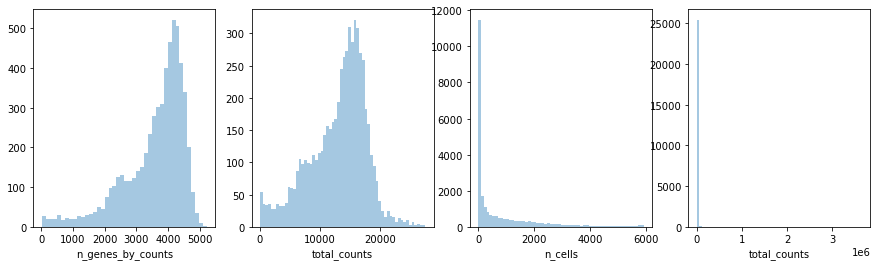

In [22]:
# QC
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"], kde=False, bins=60, ax=axs[1])
sns.distplot(adata.var["n_cells"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.var["total_counts"], kde=False, bins=60, ax=axs[3])

In [23]:
# Preprocessing for Mouse embryo data
sp.pp.filter_cells(adata, min_genes = np.percentile(adata.obs['n_genes_by_counts'], 5))
sp.pp.filter_genes(adata, min_cells=30)
print('Filtered genes')

sp.pp.normalize_total(adata, inplace=True)
print('Normalized')

sp.pp.log1p(adata)
print('logd')

Filtered genes
Normalized
logd


In [ ]:
# Preprocessing for Mouse brain data
sp.pp.filter_genes(adata, min_cells=30)
print('Filtered genes')

sp.pp.normalize_total(adata, inplace=True)
print('Normalized')

sp.pp.log1p(adata)
print('logd')

In [10]:
# determine the number of low-frequency FMs and high-frequency FMs
(ratio_low, ratio_high) = spg.gft.determine_frequency_ratio(adata, ratio_neighbors=1, spatial_info='spatial')
# calculation
gene_df = spg.detect_svg(adata,
                         spatial_info='spatial',
                         ratio_low_freq=ratio_low,
                         ratio_high_freq=ratio_high,
                         ratio_neighbors=1,
                         filter_peaks=True,
                         S=6)
# S determines the  sensitivity of kneedle algorithm
# extract spaitally variable genes
svg_list = gene_df[gene_df.cutoff_gft_score][gene_df.qvalue < 0.05].index.tolist()
print("The number of SVGs: ", len(svg_list))

Obatain the Laplacian matrix
The precalculated low-frequency FMs are USED
The precalculated high-frequency FMs are USED
Graph Fourier Transform finished!
SVG ranking could be found in adata.var['svg_rank']
The spatially variable genes judged by gft_score could be found 
          in adata.var['cutoff_gft_score']
Gene signals in frequency domain when detect SVGs could be found
          in adata.varm['freq_domain_svg']
The number of SVGs:  2000


In [ ]:
with open('SVG_SpaGFT_embryo', 'wb') as f:
    pickle.dump(svg_list, f)

In [ ]:
with open('SVG_SpaGFT_brain', 'wb') as f:
    pickle.dump(svg_list, f)